In [1]:
# ! kaggle competitions download -c playground-series-s5e7
# ! unzip playground-series-s5e7.zip -d data
# ! rm playground-series-s5e7.zip

In [2]:
from typing import Dict, Optional, Union

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import optuna

from sklearn.model_selection import StratifiedKFold
import numpy as np

from datetime import datetime

%matplotlib inline

# Load model and EDA

In [3]:
train_df = pd.read_csv("./data/train.csv", index_col="id")

train_df.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [4]:
train_df.describe().columns

Index(['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Friends_circle_size', 'Post_frequency'],
      dtype='object')

In [5]:
# Check if there are any missing values
missing_values = train_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])
print("Total rows:", len(train_df))

Missing values in each column:
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
dtype: int64
Total rows: 18524


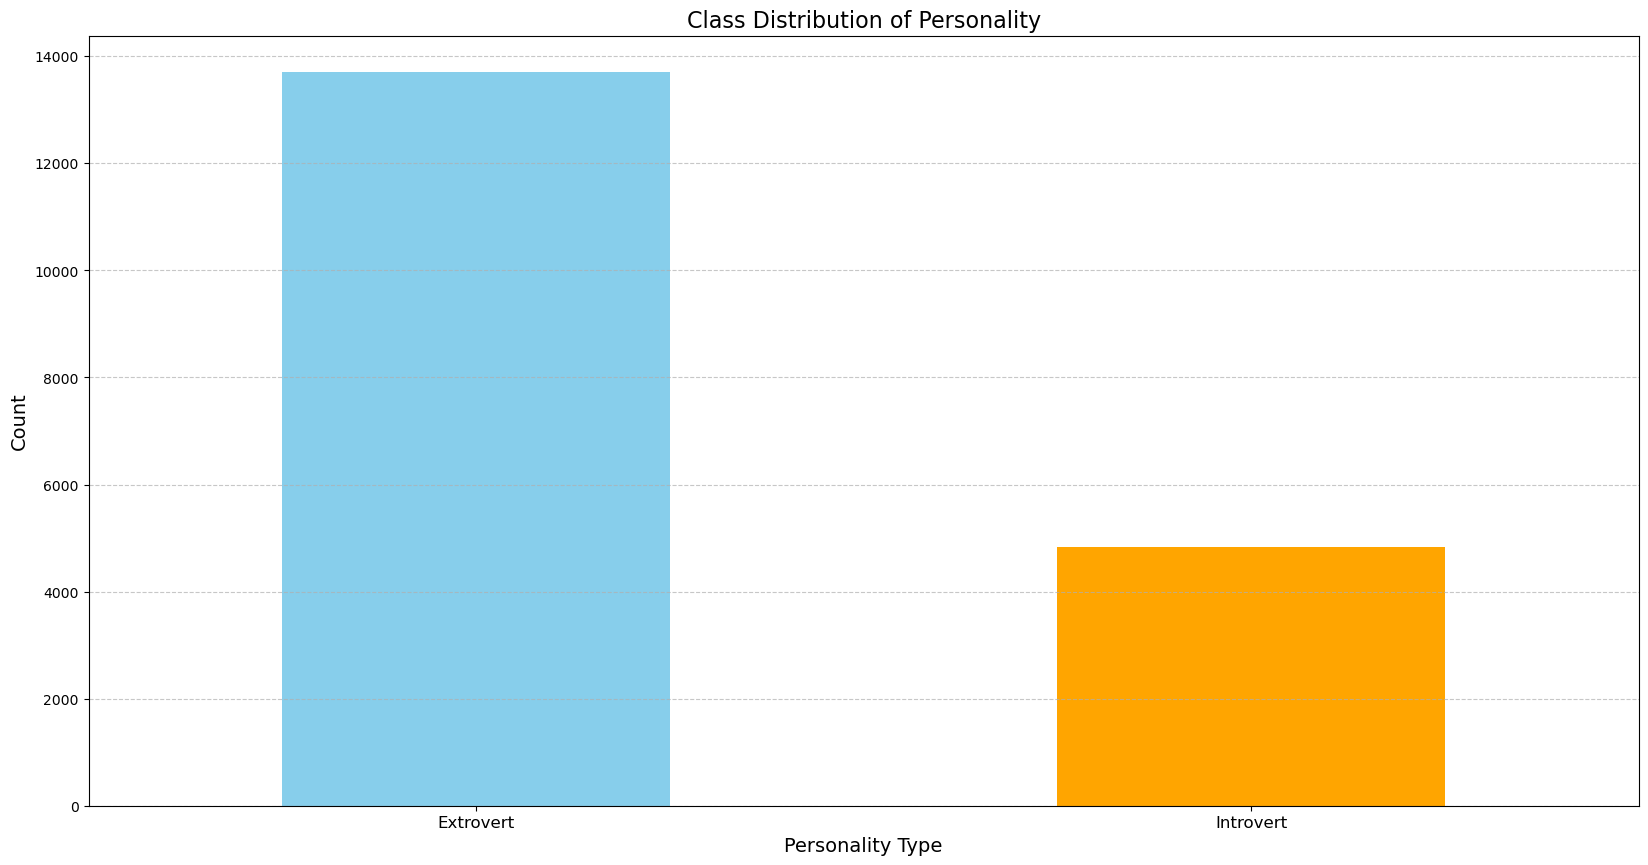

In [6]:
# Visualize the class distribution with improved chart
plt.figure(figsize=(20, 10))
train_df["Personality"].value_counts().plot(kind="bar", color=["skyblue", "orange"])
plt.title("Class Distribution of Personality", fontsize=16)
plt.xlabel("Personality Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

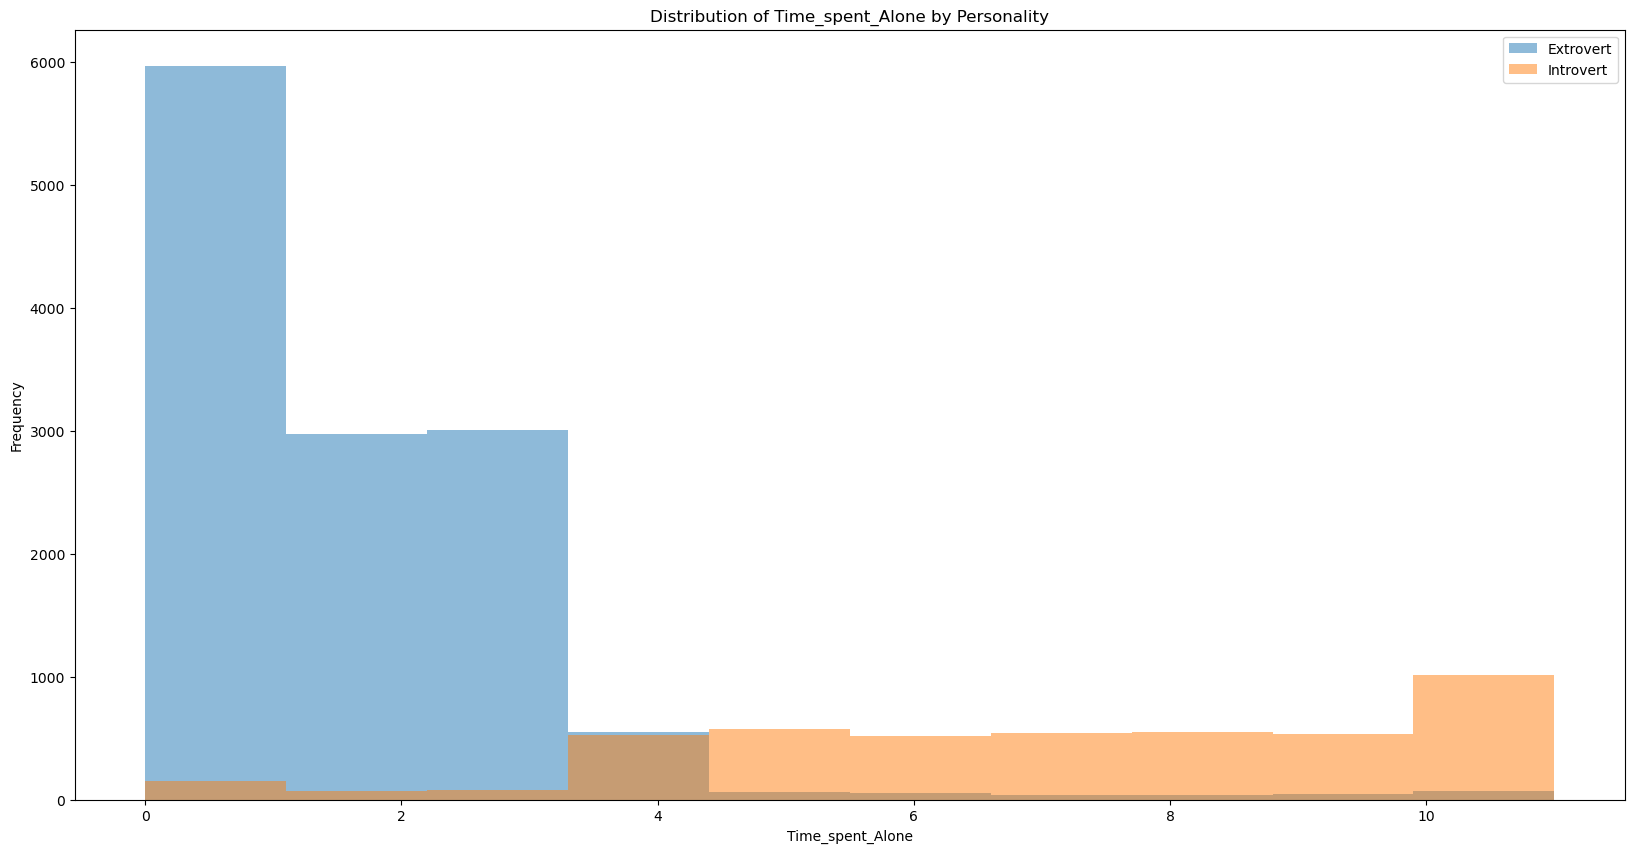

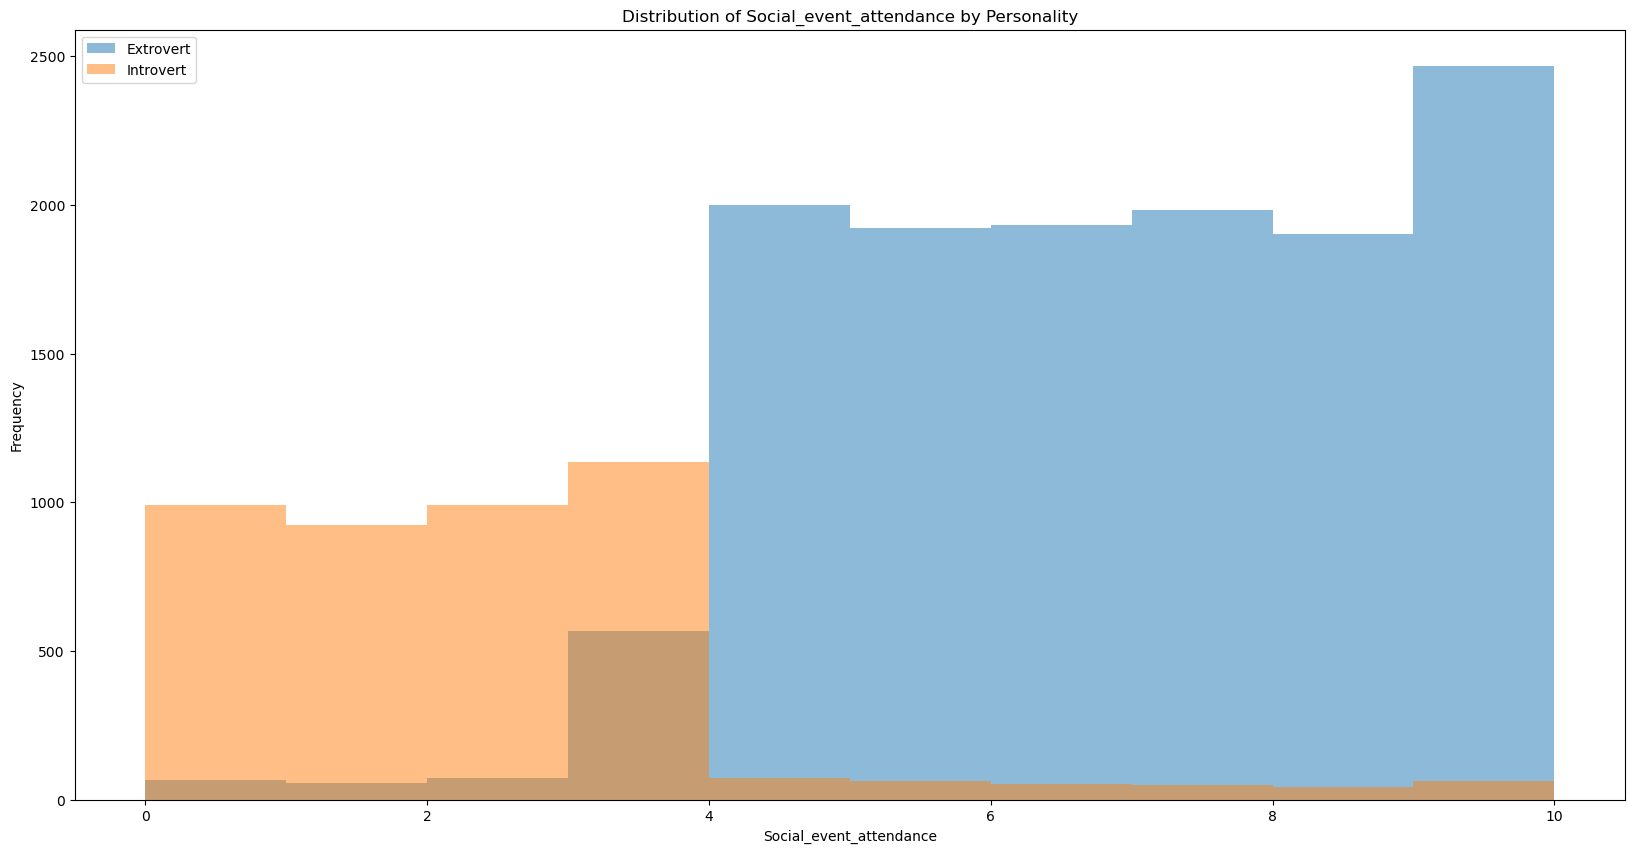

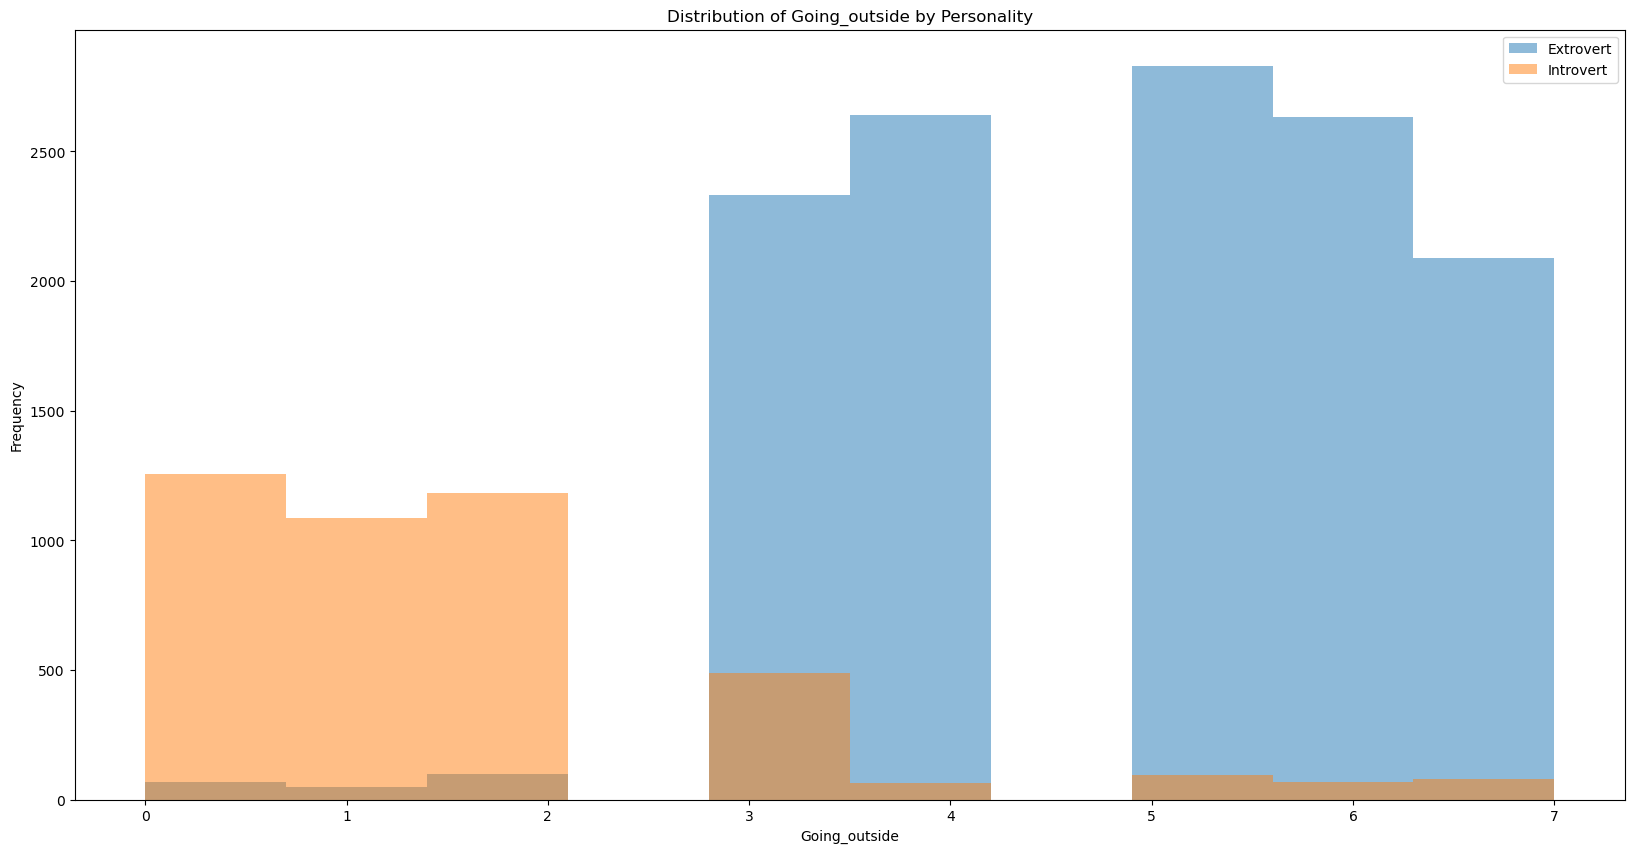

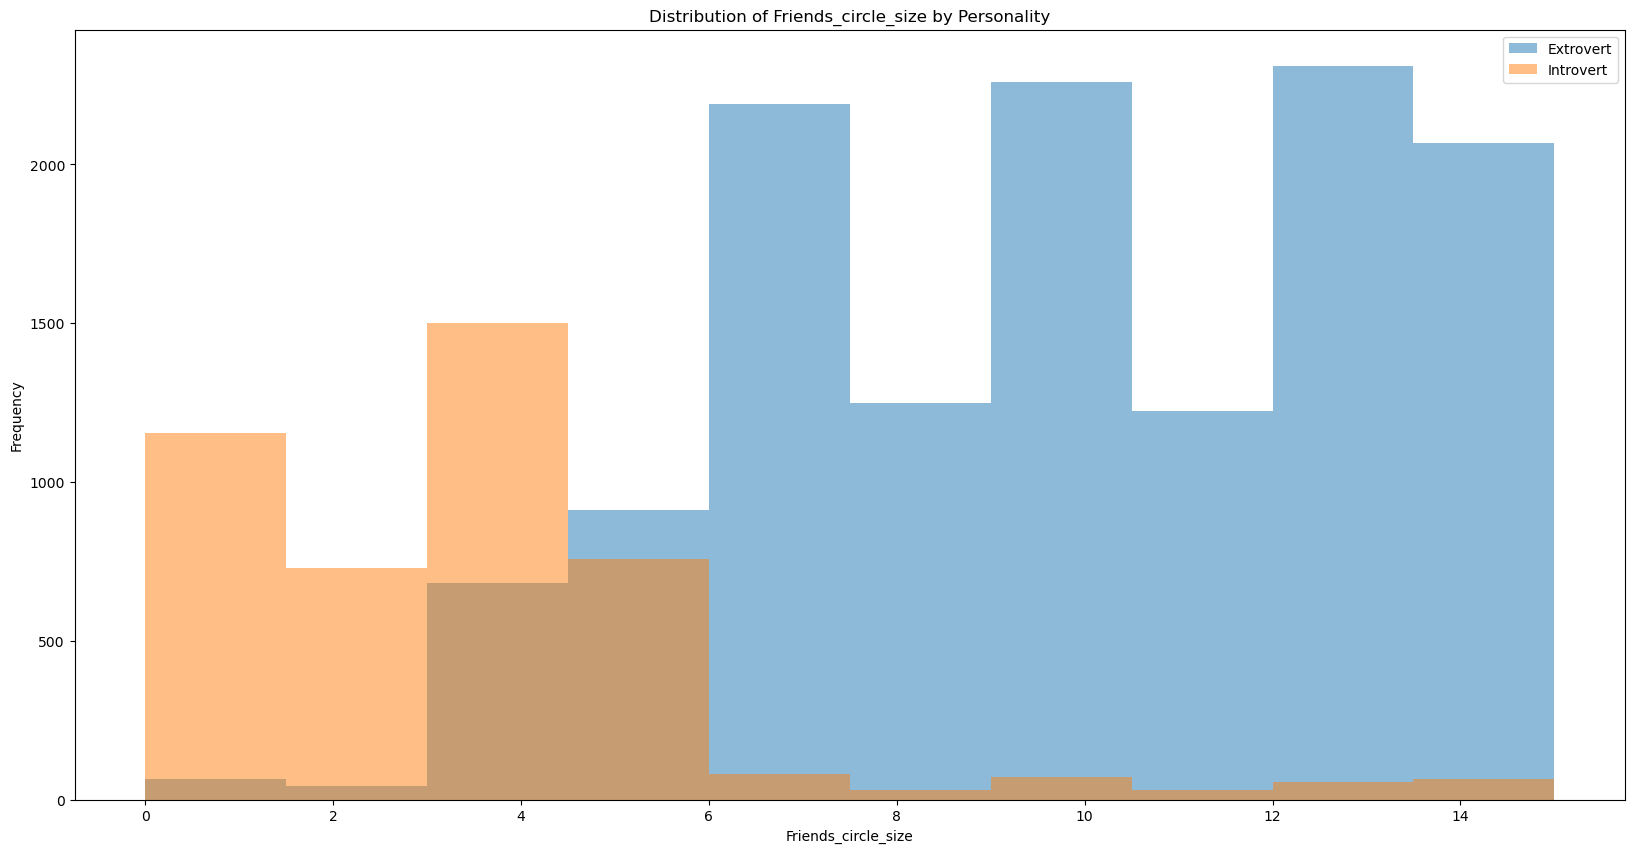

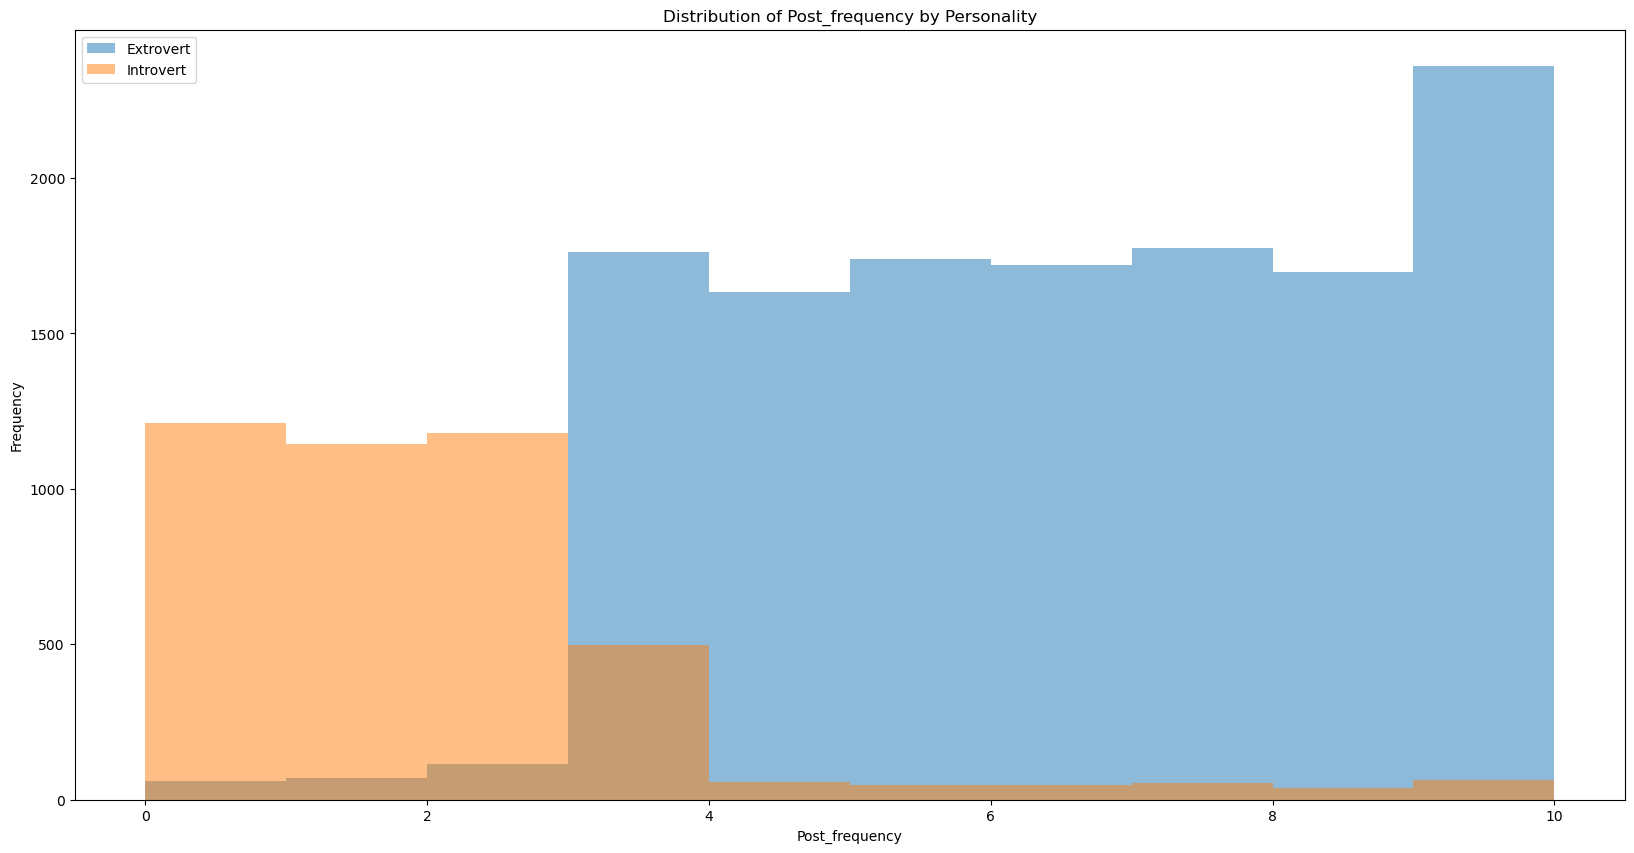

In [7]:
for col in train_df.describe().columns:
    plt.figure(figsize=(20, 10))
    train_df.groupby("Personality")[col].plot(kind="hist", alpha=0.5, legend=True)
    plt.title(f"Distribution of {col} by Personality")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [8]:
X = train_df.drop(columns=["Personality"])
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].astype("category")

y = train_df["Personality"].astype("category")

In [9]:
y

id
0        Extrovert
1        Extrovert
2        Introvert
3        Extrovert
4        Extrovert
           ...    
18519    Extrovert
18520    Extrovert
18521    Introvert
18522    Introvert
18523    Extrovert
Name: Personality, Length: 18524, dtype: category
Categories (2, object): ['Extrovert', 'Introvert']

In [10]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded: np.ndarray = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Baseline

In [11]:
# Create binary classification model with XGBoost
d_train = xgb.DMatrix(X_train, label=y_train_encoded, enable_categorical=True)
d_val = xgb.DMatrix(X_val, label=y_val_encoded, enable_categorical=True)

model = xgb.train(
    params={
        "objective": "binary:logistic",
        "max_depth": 6,
        "eta": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42,
    },
    dtrain=d_train,
    num_boost_round=2000,
    evals=[(d_train, "train"), (d_val, "val")],
    early_stopping_rounds=20,
    callbacks=[
        xgb.callback.EvaluationMonitor(
            show_stdv=True,
        ),
        xgb.callback.LearningRateScheduler(
            lambda epoch: 0.1 * (0.9**epoch),
        ),
    ],
)

[0]	train-logloss:0.49343	val-logloss:0.49234
[0]	train-logloss:0.49343	val-logloss:0.49234
[1]	train-logloss:0.43458	val-logloss:0.43255
[1]	train-logloss:0.43458	val-logloss:0.43255
[2]	train-logloss:0.39272	val-logloss:0.39024
[2]	train-logloss:0.39272	val-logloss:0.39024
[3]	train-logloss:0.36112	val-logloss:0.35844
[3]	train-logloss:0.36112	val-logloss:0.35844
[4]	train-logloss:0.33648	val-logloss:0.33355
[4]	train-logloss:0.33648	val-logloss:0.33355
[5]	train-logloss:0.31712	val-logloss:0.31399
[5]	train-logloss:0.31712	val-logloss:0.31399
[6]	train-logloss:0.30160	val-logloss:0.29829
[6]	train-logloss:0.30160	val-logloss:0.29829
[7]	train-logloss:0.28866	val-logloss:0.28530
[7]	train-logloss:0.28866	val-logloss:0.28530
[8]	train-logloss:0.27782	val-logloss:0.27446
[8]	train-logloss:0.27782	val-logloss:0.27446
[9]	train-logloss:0.26877	val-logloss:0.26537
[9]	train-logloss:0.26877	val-logloss:0.26537
[10]	train-logloss:0.26109	val-logloss:0.25761
[10]	train-logloss:0.26109	val-lo

Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.94       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705

AUC Score: 0.9738


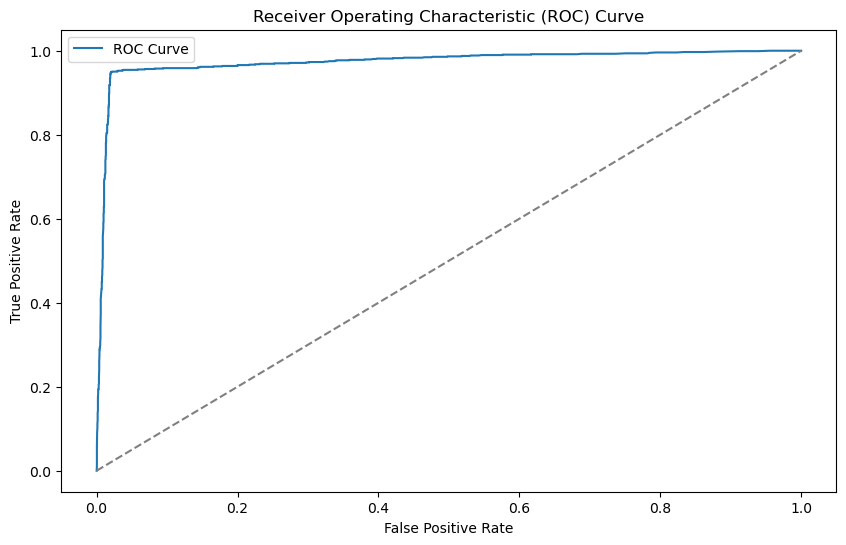

In [12]:
def evaluate_model(model, d_val, y_val_encoded):
    y_val_pred = model.predict(d_val)
    y_val_pred_binary = (y_val_pred > 0.5).astype(int)

    print("Classification Report:")
    print(classification_report(y_val_encoded, y_val_pred_binary, target_names=label_encoder.classes_))

    auc_score = roc_auc_score(y_val_encoded, y_val_pred)
    print(f"AUC Score: {auc_score:.4f}")

    fpr, tpr, thresholds = roc_curve(y_val_encoded, y_val_pred)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

evaluate_model(model, d_val, y_val_encoded)

In [13]:
test_df = pd.read_csv("./data/test.csv", index_col="id")


def predict_and_save(
    model,
    test_df: pd.DataFrame,
    label_encoder: LabelEncoder,
) -> pd.DataFrame:

    X_test = test_df.copy()

    for col in X_test.columns:
        if X_test[col].dtype == "object":
            X_test[col] = X_test[col].astype("category")

    d_test = xgb.DMatrix(X_test, enable_categorical=True)

    test_predictions = [p > 0.5 for p in model.predict(d_test)]

    X_test["Personality"] = label_encoder.inverse_transform(test_predictions)

    return X_test[["Personality"]]

In [14]:
submission_df = predict_and_save(model, test_df, label_encoder)

file_path = f"./data/submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
submission_df.to_csv(
    file_path,
    index=True,
)

In [15]:
# ! kaggle competitions submit -c playground-series-s5e7 -f "{file_path}" -m "Submission"

In [16]:
# Score: 0.974898

# Hyperparameter tuning with Optuna

In [17]:
def objective(
    trial: optuna.Trial,
    X_train: pd.DataFrame,
    y_train_encoded: np.ndarray,
    additional_params: Optional[Dict[str, Union[int, float, str, np.ndarray]]] = None,
) -> float:
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "max_depth": trial.suggest_int("max_depth", 2, 20),
        "eta": trial.suggest_float("eta", 0.005, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "lambda": trial.suggest_float("lambda", 1e-4, 20.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 20.0, log=True),
        "seed": 42,
    }

    if additional_params:
        params.update(additional_params)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, val_idx in skf.split(X_train, y_train_encoded):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train_encoded[train_idx], y_train_encoded[val_idx]

        d_train = xgb.DMatrix(X_fold_train, label=y_fold_train, enable_categorical=True)
        d_val = xgb.DMatrix(X_fold_val, label=y_fold_val, enable_categorical=True)

        model = xgb.train(
            params=params,
            dtrain=d_train,
            num_boost_round=500,
            evals=[(d_train, "train"), (d_val, "val")],
            early_stopping_rounds=20,
            verbose_eval=False,
        )

        predictions = model.predict(d_val)
        predictions_binary = [p > 0.5 for p in predictions]

        accuracy = (np.array(predictions_binary) == y_fold_val).mean()
        accuracies.append(accuracy)

    return float(np.mean(accuracies))

In [18]:
from functools import partial

In [19]:
! rm -rf optuna_study_with_default_data.db

In [20]:
study_with_default_data = optuna.create_study(
    study_name="Predict the Introverts from the Extroverts",
    direction="maximize",
    storage="sqlite:///optuna_study_with_default_data.db",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42, warn_independent_sampling=False),
    pruner= optuna.pruners.MedianPruner(
        n_startup_trials=10,
        n_warmup_steps=5,
        interval_steps=1,
        n_min_trials=5,
    ),
)

objective_with_default_data = partial(
    objective,
    X_train=X_train,
    y_train_encoded=y_train_encoded,
)

study_with_default_data.optimize(objective_with_default_data, n_trials=200)

[I 2025-07-02 19:52:32,912] A new study created in RDB with name: Predict the Introverts from the Extroverts
[I 2025-07-02 19:52:33,193] Trial 0 finished with value: 0.9678117156126641 and parameters: {'max_depth': 9, 'eta': 0.28546072039092524, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 4, 'lambda': 0.0006713231619759604, 'alpha': 0.00020319029944803154}. Best is trial 0 with value: 0.9678117156126641.
[I 2025-07-02 19:52:33,479] Trial 1 finished with value: 0.9681490747559988 and parameters: {'max_depth': 18, 'eta': 0.1823289284642466, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'min_child_weight': 20, 'lambda': 2.587041577736257, 'alpha': 0.0013354142153961532}. Best is trial 1 with value: 0.9681490747559988.
[I 2025-07-02 19:52:33,969] Trial 2 finished with value: 0.9684864794453227 and parameters: {'max_depth': 5, 'eta': 0.059104330406762974, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378

In [21]:
model = xgb.train(
    params=study_with_default_data.best_params
    | {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "seed": 42,
    },
    dtrain=d_train,
    num_boost_round=100,
    evals=[(d_train, "train")],
    early_stopping_rounds=10,
)

[0]	train-logloss:0.55402
[1]	train-logloss:0.53581
[2]	train-logloss:0.51904
[3]	train-logloss:0.50312
[4]	train-logloss:0.48812
[5]	train-logloss:0.47400
[6]	train-logloss:0.46081
[7]	train-logloss:0.44820
[8]	train-logloss:0.43619
[9]	train-logloss:0.42478
[10]	train-logloss:0.41390
[11]	train-logloss:0.40359
[12]	train-logloss:0.39376
[13]	train-logloss:0.38438
[14]	train-logloss:0.37537
[15]	train-logloss:0.36671
[16]	train-logloss:0.35848
[17]	train-logloss:0.35061
[18]	train-logloss:0.34301
[19]	train-logloss:0.33568
[20]	train-logloss:0.32870
[21]	train-logloss:0.32195
[22]	train-logloss:0.31548
[23]	train-logloss:0.30926
[24]	train-logloss:0.30322
[25]	train-logloss:0.29748
[26]	train-logloss:0.29193
[27]	train-logloss:0.28652
[28]	train-logloss:0.28138
[29]	train-logloss:0.27641
[30]	train-logloss:0.27160
[31]	train-logloss:0.26695
[32]	train-logloss:0.26247
[33]	train-logloss:0.25812
[34]	train-logloss:0.25397
[35]	train-logloss:0.24987
[36]	train-logloss:0.24594
[37]	train-

Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705

AUC Score: 0.9736


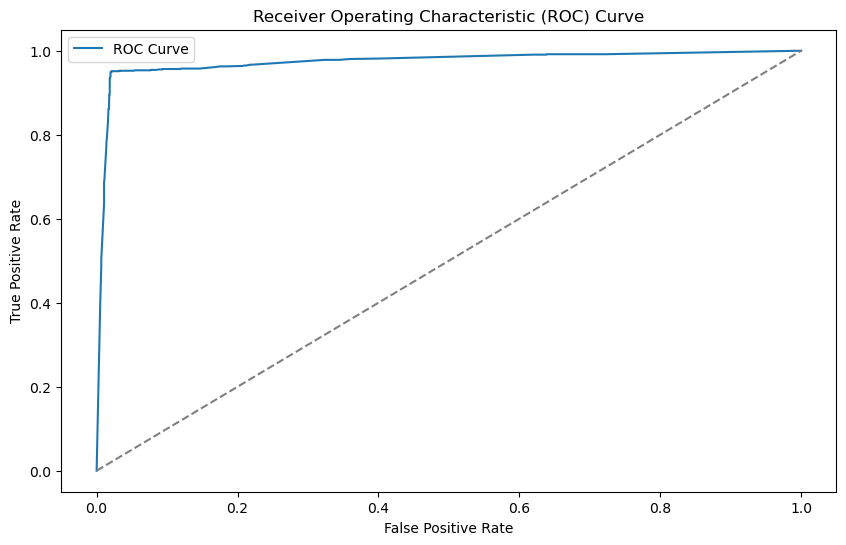

In [22]:
evaluate_model(model, d_val, y_val_encoded)

In [23]:
submission_df = predict_and_save(model, test_df, label_encoder)

file_path = f"./data/submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
submission_df.to_csv(
    file_path,
    index=True,
)

# ! kaggle competitions submit -c playground-series-s5e7 -f "{file_path}" -m "Submission"

# Fill missing values by using sklearn Imputer

In [24]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [25]:
imputers = {}

for label_class in train_df["Personality"].unique():
    class_data = train_df[train_df["Personality"] == label_class].drop(
        columns=["Personality"]
    )
    class_data = class_data.select_dtypes(include=["number"]).copy()

    imputer = IterativeImputer(random_state=42)
    imputer.fit(class_data)
    imputers[label_class] = imputer


## Use IterativeImputer to fill missing values

In [26]:
def impute_class_data(
    feature_df: pd.DataFrame, labels: pd.Series, imputers: Dict[str, IterativeImputer]
) -> pd.DataFrame:
    new_df = feature_df.copy()
    for label_class, imputer in imputers.items():
        class_mask = labels == label_class
        class_data = feature_df[class_mask].select_dtypes(include=["number"])
        imputed_data = imputer.transform(class_data)

        new_df.loc[class_mask, class_data.columns] = imputed_data
    return new_df


X_train_imputed = impute_class_data(X_train, y_train, imputers)
X_val_imputed = impute_class_data(X_val, y_val, imputers)

# Calculate sample weights and positive weights

In [27]:
# from sklearn.utils.class_weight import compute_sample_weight


# sample_weight = compute_sample_weight(
#     class_weight="balanced",
#     y=y_train_encoded,
# ).astype(np.float32)

# print(f"Sample weights: {sample_weight[:10]}... (showing first 10)")

In [28]:
pos_class_weight = float(
    len(y_train_encoded) / (2 * np.sum(y_train_encoded == 1)) if np.sum(y_train_encoded == 1) > 0 else 1.0
)

print(f"Positive class weight: {pos_class_weight:.4f}")

Positive class weight: 1.9196


In [29]:
! rm -rf optuna_study_with_imputed_data.db

In [30]:
objective_with_imputed_data = partial(
    objective,
    X_train=X_train_imputed,
    y_train_encoded=y_train_encoded,
    additional_params={
        "scale_pos_weight": pos_class_weight,
    },
)

study_with_imputed_data = optuna.create_study(
    study_name="Predict the Introverts from the Extroverts with Imputed Data",
    direction="maximize",
    storage="sqlite:///optuna_study_with_imputed_data.db",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42, warn_independent_sampling=False),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=10,
        n_warmup_steps=5,
        interval_steps=1,
        n_min_trials=5,
    ),
)

study_with_imputed_data.optimize(objective_with_imputed_data, n_trials=200)


[I 2025-07-02 19:54:40,403] A new study created in RDB with name: Predict the Introverts from the Extroverts with Imputed Data
[I 2025-07-02 19:54:40,698] Trial 0 finished with value: 0.9678791009039512 and parameters: {'max_depth': 9, 'eta': 0.28546072039092524, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 4, 'lambda': 0.0006713231619759604, 'alpha': 0.00020319029944803154}. Best is trial 0 with value: 0.9678791009039512.
[I 2025-07-02 19:54:40,965] Trial 1 finished with value: 0.9684190258350516 and parameters: {'max_depth': 18, 'eta': 0.1823289284642466, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'min_child_weight': 20, 'lambda': 2.587041577736257, 'alpha': 0.0013354142153961532}. Best is trial 1 with value: 0.9684190258350516.
[I 2025-07-02 19:54:41,362] Trial 2 finished with value: 0.9686214549848492 and parameters: {'max_depth': 5, 'eta': 0.059104330406762974, 'subsample': 0.6521211214797689, 'colsample

In [31]:
study_with_default_data.best_value, study_with_imputed_data.best_value

(0.9688238841346468, 0.9693637179737683)

In [32]:
model = xgb.train(
    params=study_with_imputed_data.best_params
    | {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "seed": 42,
        "scale_pos_weight": pos_class_weight,
    },
    dtrain=xgb.DMatrix(X_train_imputed, label=y_train_encoded, enable_categorical=True),
    num_boost_round=200,
    evals=[(d_train, "train")],
    early_stopping_rounds=20
)



[0]	train-logloss:0.48113
[1]	train-logloss:0.39410
[2]	train-logloss:0.33281
[3]	train-logloss:0.28548
[4]	train-logloss:0.25026
[5]	train-logloss:0.22403
[6]	train-logloss:0.20457
[7]	train-logloss:0.19091
[8]	train-logloss:0.18046
[9]	train-logloss:0.17254
[10]	train-logloss:0.16675
[11]	train-logloss:0.16127
[12]	train-logloss:0.15848
[13]	train-logloss:0.15569
[14]	train-logloss:0.15513
[15]	train-logloss:0.15487
[16]	train-logloss:0.15437
[17]	train-logloss:0.15300
[18]	train-logloss:0.14995
[19]	train-logloss:0.14889
[20]	train-logloss:0.14835
[21]	train-logloss:0.14799
[22]	train-logloss:0.14783
[23]	train-logloss:0.14807
[24]	train-logloss:0.14722
[25]	train-logloss:0.14690
[26]	train-logloss:0.14803
[27]	train-logloss:0.14822
[28]	train-logloss:0.14794
[29]	train-logloss:0.14777
[30]	train-logloss:0.14671
[31]	train-logloss:0.14682
[32]	train-logloss:0.14746
[33]	train-logloss:0.14780
[34]	train-logloss:0.14744
[35]	train-logloss:0.14749
[36]	train-logloss:0.14771
[37]	train-

Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.93      0.94      0.94       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705

AUC Score: 0.9704


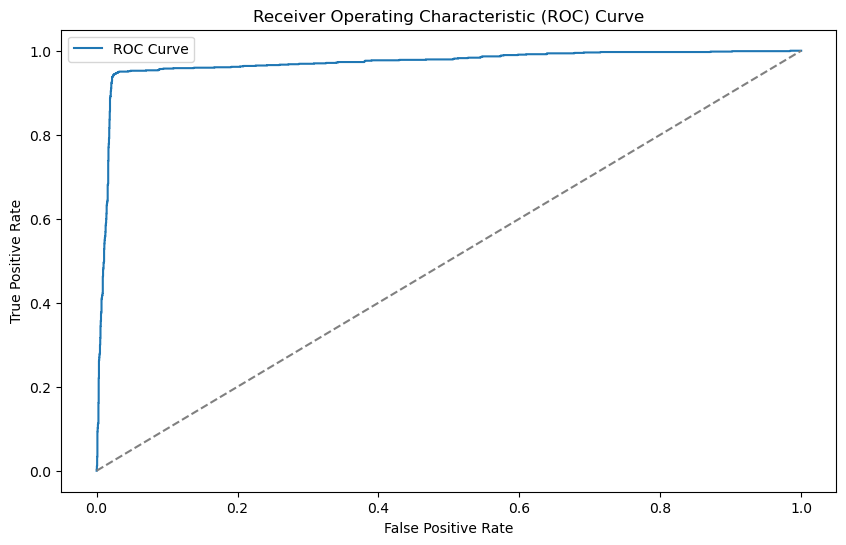

In [33]:
evaluate_model(model, d_val, y_val_encoded)